In [3]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
import warnings
import umap.umap_ as mp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import BisectingKMeans
from concurrent.futures import ThreadPoolExecutor

In [4]:
warnings.filterwarnings("ignore")

<span style="color: cyan;"> **Einlesen von Daten** </span>

In [5]:
# read the data

df = pd.read_csv("wiki_movie_plots_deduped.csv")
df.head(1)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."


In [6]:
raw_data = df['Plot'].values.tolist()
print(f"There are {len(raw_data)} Texts")

There are 34886 Texts


<span style="color: cyan;"> **Vorbereitung von Daten** </span>

In [7]:
def my_nltk_tokenizer(doc):
    stopwörter = list(set(stopwords.words('english')))
    ps = PorterStemmer()
    tokens_lis = word_tokenize(doc, language='english') 
    tokens_lis = [element.lower() for element in tokens_lis if element.isalnum()]
    tokens_lis = [element for element in tokens_lis if element not in stopwörter]
    tokens_lis = [ps.stem(element) for element in tokens_lis]
    return  tokens_lis

<span style="color: cyan;"> **Merkmaleselektion mithilfe von TFIDF** </span>

In [8]:
# using Tf-idf Vectorizer 
vectorizer = TfidfVectorizer(tokenizer=my_nltk_tokenizer, min_df=5)
vecs_tfidf = vectorizer.fit_transform(raw_data)

<span style="color: cyan;"> **Clustering Methoden** </span>

In [7]:
reducer = mp.UMAP()
embedding = reducer.fit_transform(vecs_tfidf)
print(f" The shape of embedding {embedding.shape}")

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 The shape of embedding (34886, 2)


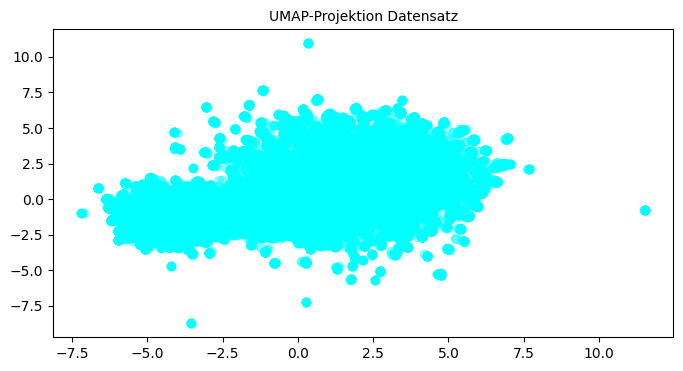

In [8]:
# ploting the UMAP 
plt.figure(figsize=(8, 4))
plt.title('UMAP-Projektion Datensatz', fontsize=10)
plt.scatter(embedding[:, 0], embedding[:, 1], alpha=0.4, c='cyan')
plt.show()

<span style="color: cyan;"> **KMeans** </span>

#### I would like to find the optimum number of clusters so i will use elbow method and calculate the wcss within cluster sum of squares 

In [22]:
def compute_wcss(n_clusters, vecs_tfidf):
    km = KMeans(n_clusters=n_clusters)
    km.fit(vecs_tfidf)
    return km.inertia_

In [18]:
wcss = []
for i in range(1, 81):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(vecs_tfidf)
    wcss.append(kmeans.inertia_)

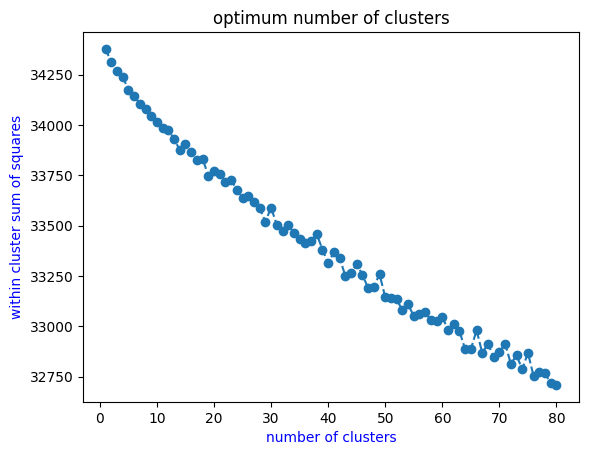

In [19]:
plt.plot(range(1, 81), wcss, marker='o', linestyle='--')
plt.xlabel('number of clusters', color='blue')
plt.ylabel('within cluster sum of squares', color='blue')
plt.title('optimum number of clusters')
plt.show()

In [31]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans = kmeans.fit(vecs_tfidf)

In [26]:
kmeans

KMeans(n_clusters=15, random_state=42)

In [35]:
print(f" The labels : {kmeans.labels_}")

 The labels : [ 7  7  7 ... 13  7  9]


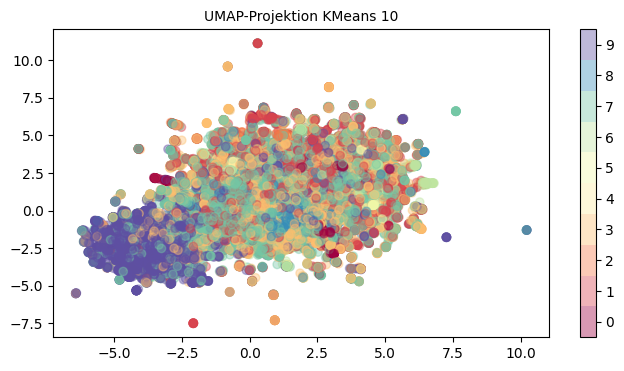

In [39]:
plt.figure(figsize=(8, 4))
plt.title('UMAP-Projektion KMeans 10', fontsize=10)
plt.scatter(embedding[:, 0], embedding[:, 1], c=kmeans.labels_, cmap='Spectral', alpha=0.4)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.savefig("graphs/10_Kmeans_clusters.png")

<span style="color: cyan;"> **DBSCAN Clustering** </span>

In [15]:
clustering = DBSCAN(eps=3, min_samples=10).fit(vecs_tfidf)

In [16]:
clustering

DBSCAN(eps=3, min_samples=10)

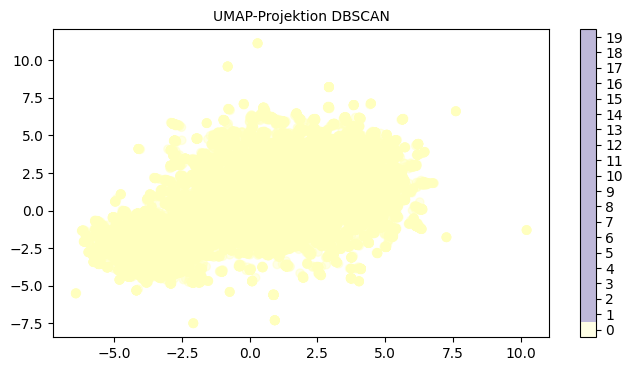

In [41]:
plt.figure(figsize=(8, 4))
plt.title('UMAP-Projektion DBSCAN', fontsize=10)
plt.scatter(embedding[:, 0], embedding[:, 1], c=clustering.labels_, cmap='Spectral', alpha=0.4)
plt.colorbar(boundaries=np.arange(21)-0.5).set_ticks(np.arange(20))
plt.savefig("graphs/DBSCAN_clusters.png")

In [27]:
bisect_means = BisectingKMeans(n_clusters=15, random_state=42).fit(vecs_tfidf)

In [28]:
bisect_means.labels_

array([ 1,  2,  0, ..., 10, 12, 14], dtype=int32)

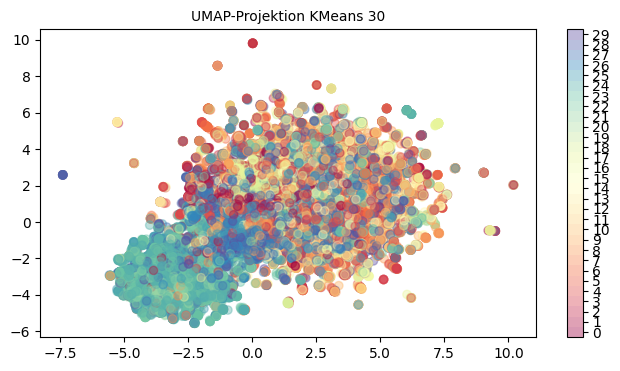

In [23]:
plt.figure(figsize=(8, 4))
plt.title('UMAP-Projektion KMeans 30', fontsize=10)
plt.scatter(embedding[:, 0], embedding[:, 1], c=bisect_means.labels_, cmap='Spectral', alpha=0.4)
plt.colorbar(boundaries=np.arange(31)-0.5).set_ticks(np.arange(30))
plt.savefig("graphs/bisect_means_30.png")

<span style="color: cyan;"> **Implementierung von Rand index** </span>

In [30]:
kmeans

KMeans(n_clusters=15, random_state=42)

In [36]:
from sklearn.metrics import adjusted_rand_score
rand_index = adjusted_rand_score(kmeans.labels_, bisect_means.labels_)
print(f"The rand index between Kmeans and Bisect is {round(rand_index,4)}")

The rand index between Kmeans and Bisect is 0.1587


<span style="color: cyan;"> **Implementierung von Jaccard index** </span>

In [39]:
len(bisect_means.labels_)

34886

In [40]:
from sklearn.metrics import jaccard_score

binary_labels1 = [1 if label == 0 else 0 for label in kmeans.labels_]
binary_labels2 = [1 if label == 0 else 0 for label in bisect_means.labels_]

jaccard_similarity = jaccard_score(binary_labels1, binary_labels2)
print(f"The rand index between Kmeans and Bisect is {round(jaccard_similarity,4)}")

The rand index between Kmeans and Bisect is 0.0025


<span style="color: cyan;"> **Normalized Mutual Information** </span>

In [42]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(kmeans.labels_, bisect_means.labels_)
print(f"The rand index between Kmeans and Bisect is {round(nmi,4)}")

The rand index between Kmeans and Bisect is 0.3315
